In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
def preprocess_data(file_path):
    # Load the data
    df = pd.read_csv(file_path)

    print(df.head())
    print(df.tail())
    print(df.info())
    print(df.describe())

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.set_index('Date', inplace=True)

    # Fill missing values with the mean
    df.fillna(df.mean(), inplace=True)

    # Detect and handle outliers using z-scores
    z_scores = (df - df.mean()) / df.std()
    
    # Use mask to replace values where condition is True
    df = df.mask(z_scores.abs() > 3)  

    # Resample to daily intervals
    df = df.resample('D').agg({'Open': 'first', 'High': 'max', 'Low': 'min',
                               'Close': 'last', 'Adj Close': 'last', 'Volume': 'sum'})

    # Normalize/scaling using StandardScaler
    scaler = StandardScaler()
    numerical_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    # Feature engineering (moving average)
    df['MA20'] = df['Close'].rolling(window=20).mean()

    df.to_csv("preprocessed_btc_data.csv")

In [3]:
preprocess_data("C:/Users/vijay/Downloads/IITR/BTC-USD.csv")

         Date          Open          High           Low         Close  \
0  2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
1  2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2  2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
3  2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
4  2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   

      Adj Close       Volume  
0  13657.200195  10291200000  
1  14982.099609  16846600192  
2  15201.000000  16871900160  
3  15599.200195  21783199744  
4  17429.500000  23840899072  
            Date          Open          High           Low         Close  \
1487  2022-01-27  36841.878906  37148.324219  35629.281250  37138.234375   
1488  2022-01-28  37128.445313  37952.878906  36211.109375  37784.332031   
1489  2022-01-29  37780.714844  38576.261719  37406.472656  38138.179688   
1490  2022-01-30  38151.917969  38266.339844  37437.710938  37917.60156

In [4]:
def mean_reversion_strategy(df, window=20, threshold=2):
    df['MA'] = df['Close'].rolling(window=window).mean()
    df['std'] = df['Close'].rolling(window=window).std()
    df['z_score'] = (df['Close'] - df['MA']) / df['std']

    signals = []

    for i in range(1, len(df)):
        if df['z_score'].iloc[i] > threshold:
            signals.append(1)  # Buy
        elif df['z_score'].iloc[i] < -threshold:
            signals.append(-1)  # Sell
        else:
            signals.append(0)  # Hold
    return signals

In [5]:
df = pd.read_csv("preprocessed_btc_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.set_index('Date', inplace=True)
signals = mean_reversion_strategy(df)

In [7]:
def advanced_mean_reversion_strategy(data, atr_window=14, risk_factor=2):
    data['20_MA'] = data['Close'].rolling(window=20).mean()

    # Calculate ATR for volatility
    data['ATR'] = data['High'] - data['Low']
    data['ATR'] = data['ATR'].ewm(span=atr_window, adjust=False).mean()

    # Set dynamic oversold and overbought thresholds based on ATR
    data['Oversold_Threshold'] = -risk_factor * data['ATR']
    data['Overbought_Threshold'] = risk_factor * data['ATR']

    # Generate signals
    data['Signal'] = 0
    data.loc[data['Close'] < (1 + data['Oversold_Threshold'] / 100) * 
    data['20_MA'], 'Signal'] = 1
    
    data.loc[data['Close'] > (1 + data['Overbought_Threshold'] / 100) * 
    data['20_MA'], 'Signal'] = -1

    # Execute trades
    data['Position'] = data['Signal'].diff()
    data['Position'].fillna(0, inplace=True)

    # Calculate daily returns
    data['Daily_Returns'] = data['Close'].pct_change()

    # Calculate trade returns
    data['Trade_Returns'] = data['Position'].shift(1) * data['Daily_Returns']

    # Calculate stop-loss levels
    data['Stop_Loss'] = data['Close'] - data['Oversold_Threshold']
    data['Stop_Loss'].fillna(0, inplace=True)

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['20_MA'], label='20-day MA')
    plt.scatter(data[data['Position'] == 1].index, data[data['Position'] == 1]
                ['Close'], marker='^', color='g', label='Buy Signal')
    
    plt.scatter(data[data['Position'] == -1].index, data[data['Position'] == -1]
                ['Close'], marker='v', color='r', label='Sell Signal')
    
    plt.plot(data['Stop_Loss'], label='Stop Loss', linestyle='--', color='orange')
    
    plt.title('Advanced Mean-Reversion Strategy for BTC/USDT')
    plt.legend()
    plt.show()

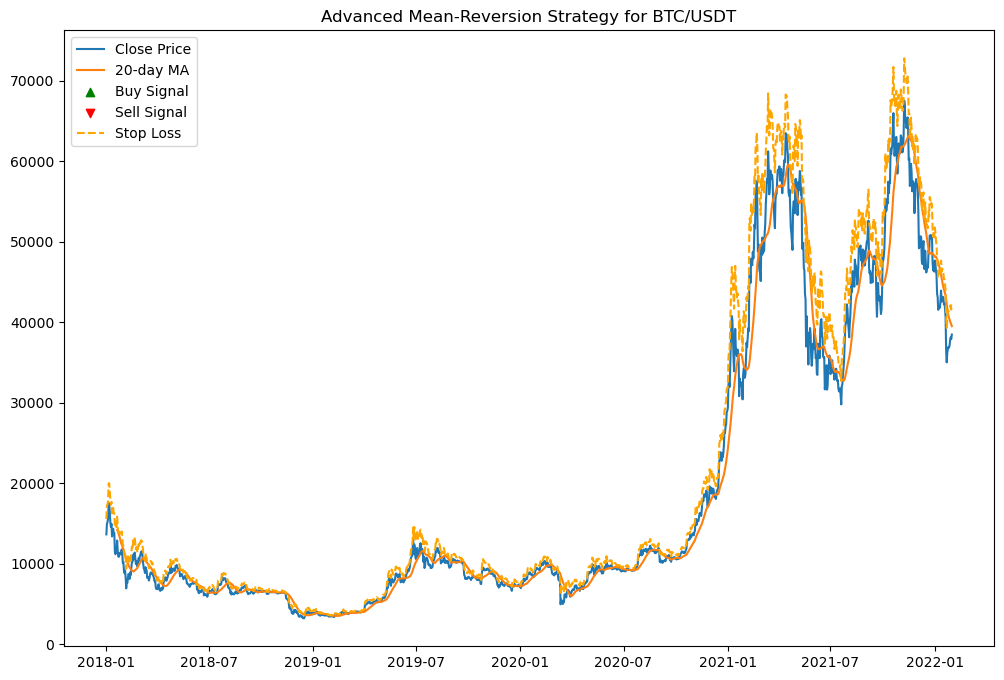

In [8]:
data = pd.read_csv('C:/Users/vijay/Downloads/IITR/BTC-USD.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
advanced_mean_reversion_strategy(data)

In [9]:
def backtest_strategy(strategy_function, data, transaction_cost=0.0015):
    # Implement backtesting with transaction costs and slippage
    signals = strategy_function(data.copy())
    signals = pd.Series(signals)  # Convert list to Series if necessary
    positions = signals.diff()
    positions.fillna(0, inplace=True)

    # Calculate actual returns, incorporating slippage and transaction costs
    actual_returns = positions.shift(1) * data['Close'].pct_change() * 
    (1 - transaction_cost)
    
    actual_returns.iloc[0] = 0  # Correct the first return

    # Calculate cumulative returns
    cumulative_returns = (1 + actual_returns).cumprod()
    
    return cumulative_returns.iloc[-1], actual_returns.std() 

In [10]:
data = pd.read_csv('C:/Users/vijay/Downloads/IITR/BTC-USD.csv')

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

preprocess_data("C:/Users/vijay/Downloads/IITR/BTC-USD.csv")

         Date          Open          High           Low         Close  \
0  2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
1  2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2  2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
3  2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
4  2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   

      Adj Close       Volume  
0  13657.200195  10291200000  
1  14982.099609  16846600192  
2  15201.000000  16871900160  
3  15599.200195  21783199744  
4  17429.500000  23840899072  
            Date          Open          High           Low         Close  \
1487  2022-01-27  36841.878906  37148.324219  35629.281250  37138.234375   
1488  2022-01-28  37128.445313  37952.878906  36211.109375  37784.332031   
1489  2022-01-29  37780.714844  38576.261719  37406.472656  38138.179688   
1490  2022-01-30  38151.917969  38266.339844  37437.710938  37917.60156

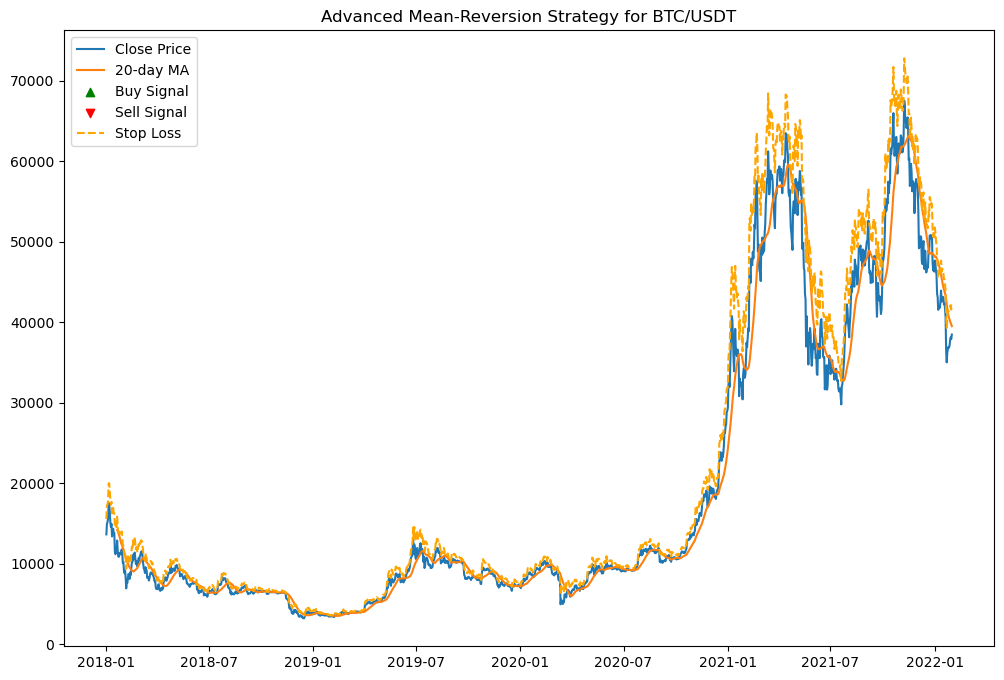

In [11]:
# Backtest the strategies
mean_reversion_results = backtest_strategy(mean_reversion_strategy, data.copy())

advanced_mean_reversion_results = 
backtest_strategy(advanced_mean_reversion_strategy, data.copy())